## PDS Price Predictor

Why is a Yellow Taxi Cab from the Empire State Building to Times Square $20? In this project, we will explore the justifications behind the pricing of Yellow Taxi Cabs in New York City.
By understanding the relevant features associated with a ride, we can develop a model that estimates how much a particular Yellow Taxi Cab ride will cost. Finally, using our model, we will directly compare the prices an Uber and a Yellow Taxi Cab would charge for the same trip in New York City. Our ultimate goal is to answer the question "Do Uber and Yellow Taxi set prices according to a similar model?". In addition, we aim to use this answer to provide users with recommendations on which taxi service, Uber or Yellow Taxi Cab, to take for a given trip in New York City. 

<img src="https://github.com/ComputAni/PDS-Price-Predictor/raw/master/UberVsTaxi.jpg">

### Table of Contents

- [Introduction](#Introduction)
- [Getting the Data](#Getting-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Linear Model Take 1](#Linear-Model-Take-1)
- [Linear Model Take 2](#Linear-Model-Take-2)
- [Gradient Boosting Model](#Gradient-Boosting-Model)
- [PCA](#PCA)
- [Compare and Contrast with Uber](#Compare-and-Contrast-with-Uber)

First, install the geopy and sodapy modules via `pip`:
    
    $ pip install geopy
    
    $ pip install sodapy
    
Next, make sure the following imports work for you:

In [3]:
# Basic Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, requests, re
from bs4 import BeautifulSoup
from unicodedata import normalize
%matplotlib inline
# Data
from sodapy import Socrata
# Machine Learning Modules
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
# Geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
# Datetime, Holiday imports
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
# Uber API related includes
from uber_rides.session import Session
from uber_rides.client import UberRidesClient
import time

## Introduction

## Getting the Data

We use a dataset sampled from NYC Open Data's 2016 Yellow Taxi Trip Data, which includes trip records from all trips completed in yellow taxis from in NYC from January to June 2016. Records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations (latitude and longitude), trip distances, and much more. For more information, check out: https://data.cityofnewyork.us/Transportation/2016-Yellow-Taxi-Trip-Data/k67s-dv2t. 

We use the NYC Open Data API: https://dev.socrata.com/foundry/data.cityofnewyork.us/uacg-pexx to request a sample dataset of 1000000 Yellow Taxi Cab trip records. First, we create a Socrata client object below, passing `None` for the second argument since we only need to create an unauthenticated client for access to the public data. 

In [9]:
client = Socrata("data.cityofnewyork.us", None)

In [11]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
max_size = 50000
total_size = 1000000
num_chunks = total_size // max_size #Should be 200
total_data = []
results = []
print("Requesting: %d chunks" % num_chunks);
for i in range(num_chunks):
    curr_offset = max_size*i
    #results = client.get("uacg-pexx", limit=50000, offset=curr_offset)
    total_data += results

Requesting: 20 chunks


In [14]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(total_data)
print("Before scrubbing data size: ", len(results_df))
results_df = results_df[results_df.pickup_latitude != '0']
results_df = results_df[results_df.pickup_longitude != '0']
results_df = results_df[results_df.dropoff_latitude != '0']
results_df = results_df[results_df.dropoff_longitude != '0']
print("After scrubbing data size: ", len(results_df))

#Write the scraped data to our cab_data.csv file
#results_df.to_csv('cab_data.csv')

Great! Now we have our scraped dataset, now we need to create some features that represent the problem at hand.

## Feature Engineering

First, load the scraped dataset. 

In [15]:
cab_data = pd.read_csv("cab_data.csv")

Next, we need to scrub the data of any uneccessary features, as well as make sure the values are correct.

In [16]:
#Removes uneccesary columns, as we will be creating our own features.
def scrub_df(df):
    #del df['extra']
    del df['fare_amount']
    del df['improvement_surcharge']
    del df['mta_tax']
    del df['passenger_count']
    del df['payment_type']
    del df['ratecodeid']
    del df['store_and_fwd_flag']
    del df['tip_amount']
    del df['tolls_amount']
    del df['trip_distance']
    del df['vendorid']
    
    return df

In [17]:
#Clean the input dataset of columns we don't care about
basic_df = scrub_df(cab_data)

Next, the distance of each trip is an important feature that affects price. Calculate the geo distance between two lat/lon pairs.

In [5]:
#Init the geolocator for caluclating distances
geolocator = Nominatim()

#Pairs the lat/lon columns into one column (for walkscore/geolocator)
def get_latlng(df):
    def f(x,y):
        coord = "%f, %f" % (x, y)
        return coord
    
    df['start_latlng'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(lambda x: f(*x), axis=1)
    df['end_latlng'] = df[['pickup_latitude', 'pickup_longitude']].apply(lambda x: f(*x), axis=1)
    
    return df

#Given input dataframe, computes distance of trip using geolocator and start/end lat/lon positions
def get_dist(df):

    def get_d(x,y):
        return geodesic(x, y).miles

    df['distance'] = df[['start_latlng', 'end_latlng']].apply(lambda x: get_d(*x), axis=1)
    
    return df

In [6]:
df_with_latlng = get_latlng(basic_df)
df_with_dist = get_dist(df_with_latlng)

Furthermore, we found that particular date trends, such as time of day, holidays, and other date specific characteristics could potentially affect demand of Ubers, and therefore price. 
Specifically, we decomposed each cab query into years, months, days, hours, minutes, seconds, day of week, and whether or not it is a holiday.

In [30]:
def create_date_features(df, start_date, end_date):
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    # Get the list of US federal hollidays
    cal = USFederalHolidayCalendar()
    us_holidays = cal.holidays(start=start_date, end=end_date).to_pydatetime()
    
    date_feature_names = ["tpep_dropoff_datetime", "tpep_pickup_datetime"]
    date_feature_to_datetimes = {"tpep_dropoff_datetime" : [],
                                 "tpep_pickup_datetime" : []}
    for feature_name in date_feature_names:
        y, mo, d = [], [], [] # Year, Month, Day
        h, mi, s = [], [], [] # Hours, Minutes, Seconds
        day_of_week = [] # Day of the Week
        is_holiday = [] # Is the date a holiday?
        for time in df[feature_name]:
            # Extract the datetime object from the timestamp
            dt = datetime.strptime(time, dt_format)
            date_feature_to_datetimes[feature_name].append(dt)
            # Add the Year/Month/Day
            y.append(dt.year)
            mo.append(dt.month)
            d.append(dt.day)
            # Add Hour/Minute/Second
            h.append(dt.hour)
            mi.append(dt.minute)
            s.append(dt.second)
            # Add Day of the Week
            day_of_week.append(dt.weekday())
            # Add is_holiday
            y_m_d = datetime(dt.year, dt.month, dt.day)
            is_holiday.append(1 if y_m_d in us_holidays else 0)
        df[feature_name + "_years"] = y
        df[feature_name + "_months"] = mo
        df[feature_name + "_days"] = d
        df[feature_name + "_hours"] = h
        df[feature_name + "_minutes"] = mi
        df[feature_name + "_seconds"] = s
        df[feature_name + "_day_of_week"] = day_of_week
        df[feature_name + "_is_holiday"] = is_holiday
    durations = []
    for dropoff_time, pickup_time in zip(date_feature_to_datetimes["tpep_dropoff_datetime"],
                                         date_feature_to_datetimes["tpep_pickup_datetime"]):
        duration = (dropoff_time - pickup_time).total_seconds() / 60.0
        durations.append(round(duration))
    
    df["duration"] = durations
    return df

In [30]:
#Generate the new dataframe with date features
start = '2016-01-01'
end = '2016-12-31'
df_with_date = create_date_features(df_with_dist, start, end)

#Write to temporary CSV file for holding
#df_with_date.to_csv("date_data.csv")

Lastly, we also found that weather patterns have an effect on usage of transportation. Consider the case of rain, users are less likely to walk/bike longer distances if it's raining, thereby increasing demand for taxi services. Other important features included snow level, percipitation, temperature, humidity, visibility, & dew point.

In [29]:
# Get weather data for 2016 and returns dictionary of date features
# Scrapes wunderground.com weather information for greater NY area.
def init_weather_features(start_date, end_date):
    date = start_date
    date_to_features = dict()
    # weather related features to extract
    feature_names = ["Mean Temperature",
                    "Max Temperature",
                    "Min Temperature",
                    "Dew Point",
                    "Average Humidity",
                    "Precipitation",
                    "Snow",
                    "Wind Speed",
                    "Visibility"]
    while (date <= end_date):
        # station: KNYC (Central Park, New York)
        (year, month, day) = (date.year, date.month, date.day)
        #print(year, month, day)

        # Get the HTML of the weather webpage
        url_format_string = "http://www.wunderground.com/history/airport/KNYC/{year}/{month}/{day}/DailyHistory.html"
        url = url_format_string.format(year=year, month=month, day=day)
        response = requests.get(url)

        if response.status_code != 200:
            print("An error occurred while getting NYC weather data for {day}-{month}-{year}".format(
            year=year, month=month, day=day))
        else:
            features = dict()
            html = response.content
            soup = BeautifulSoup(html, "lxml")
            table = soup.find_all(attrs={'id': 'historyTable'})[0]

            table_rows = table.find_all('tr')
            feature_list = []
            found_features = [False, False, False, False, False, False, False, False, False]
            # Loop through the entries of the table to find weather features
            for tr in table_rows:
                td = tr.find_all('td')
                # normalize the text to account for string encoding
                row = [normalize('NFKD', i.text) for i in td]

                # There are multiple rows named 'snow' and 'precipitation'
                # Use len(row) > 2 to get the "right" rows
                if len(row) > 2 and row[0] in feature_names:
                    data = row[1].strip() # remove extraneous whitespace
                    result = re.sub('[^0-9.]','', data) # remove all alphabetic characters
                    if result == "": # if there's no feature value (e.g.: T, for traces of precipitation/snow)
                        result = 0
                    features[row[0]] = result
                    found_features[feature_names.index(row[0])] = True
                    feature_list.append(result)

            # If a feature is not present in the table, set it to a default value: 0
            for found_feature, feature_name in zip(found_features, feature_names):
                if (not found_feature):
                    features[feature_name] = 0
            assert(len(features) == len(feature_names))
            date_to_features[date] = features
        date = date + timedelta(1)
        
    return date_to_features

# insert method for dictionary (list of values for each key)
def dict_insert(d, key, val):
    if key in d:
        d[key].append(val)
    else:
        d[key] = [val]

# put the weather-related features into the dataframe
def create_weather_features(df, date_to_features):
    
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    weather_features = dict()
    for time in df["tpep_dropoff_datetime"]:
        # Extract the datetime object from the timestamp
        dt = datetime.strptime(time, dt_format)
        y_m_d = datetime(dt.year, dt.month, dt.day)
        weather_dict = date_to_features[y_m_d]
        for feature_name in weather_dict:
            dict_insert(weather_features, feature_name, weather_dict[feature_name])
        
    for feature_name in weather_features:
        df[feature_name] = weather_features[feature_name]
    return df

In [45]:
#Initialize the weather scraping function over the year of 2016
start_date = datetime(2016, 1, 1)
end_date = datetime(2016, 12, 31)
date_features = init_weather_features(start_date, end_date)

#Open our previously curated date related features and append our new weather features.
open_date_df = pd.read_csv("date_data.csv")
df_with_weather = create_weather_features(open_date_df, date_features)

Great! We now have a dataframe with a core set of features. Let's save it to a file! The next step is to take a closer look at our input data through an exploratory data analysis.

In [46]:
df_with_weather.head()
#df_with_weather.to_csv('data_with_features.csv')

,Unnamed: 0,Unnamed: 0.1,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,...,duration,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility
0,0,0,40.777241,-73.951744,40.776424,-73.952850,15.35,2016-04-03T00:09:40.000,2016-04-02T23:55:45.000,"40.777241, -73.951744",...,14,42,50,34,16,51,0.09,0,13,10
1,1,1,40.777611,-73.951080,40.789371,-73.943352,12.30,2016-04-22T09:45:11.000,2016-04-22T09:27:51.000,"40.777611, -73.951080",...,17,71,79,62,53,55,0,0.00,4,10
2,2,2,40.770386,-73.966476,40.761303,-73.973183,5.80,2016-04-29T20:26:47.000,2016-04-29T20:23:57.000,"40.770386, -73.966476",...,3,52,58,45,34,48,0.05,0.00,6,10
3,3,3,40.767288,-73.966675,40.764381,-73.995583,10.80,2016-04-08T11:21:10.000,2016-04-08T11:10:26.000,"40.767288, -73.966675",...,11,45,50,40,26,48,0.01,0.00,7,10
4,4,4,40.744068,-73.988991,40.754742,-73.979820,7.30,2016-04-28T09:09:32.000,2016-04-28T09:04:28.000,"40.744068, -73.988991",...,5,54,59,48,30,51,0.00,0.00,5,10


## Exploratory Data Analysis

First, we load the dataset we saved to a file in the previous section using pandas.

In [28]:
cab_data = pd.read_csv("data_with_features.csv")
del cab_data["Unnamed: 0"] # Delete extraneous columns
del cab_data["Unnamed: 0.1"]
del cab_data["Unnamed: 0.1.1"]
cab_data.head()

,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,end_latlng,distance,...,duration,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility
0,40.777241,-73.951744,40.776424,-73.952850,15.35,2016-04-03T00:09:40.000,2016-04-02T23:55:45.000,"40.777241, -73.951744","40.776424, -73.952850",0.080895,...,14,42,50,34,16,51,0.09,0.0,13,10
1,40.777611,-73.951080,40.789371,-73.943352,12.30,2016-04-22T09:45:11.000,2016-04-22T09:27:51.000,"40.777611, -73.951080","40.789371, -73.943352",0.907077,...,17,71,79,62,53,55,0.00,0.0,4,10
2,40.770386,-73.966476,40.761303,-73.973183,5.80,2016-04-29T20:26:47.000,2016-04-29T20:23:57.000,"40.770386, -73.966476","40.761303, -73.973183",0.718773,...,3,52,58,45,34,48,0.05,0.0,6,10
3,40.767288,-73.966675,40.764381,-73.995583,10.80,2016-04-08T11:21:10.000,2016-04-08T11:10:26.000,"40.767288, -73.966675","40.764381, -73.995583",1.529830,...,11,45,50,40,26,48,0.01,0.0,7,10
4,40.744068,-73.988991,40.754742,-73.979820,7.30,2016-04-28T09:09:32.000,2016-04-28T09:04:28.000,"40.744068, -73.988991","40.754742, -73.979820",0.879828,...,5,54,59,48,30,51,0.00,0.0,5,10


Inspecting the data, we notice that there are some trips that have prices less than 0! We remove rows with negative prices below.

In [29]:
price_filter = cab_data["total_amount"] > 0
cab_data = cab_data[price_filter]

While conducting EDA, we can examine the continuous features using histograms. For example, here's a histogram showing the distribution of the `total_amount` variable.

Text(0,0.5,'Frequency')

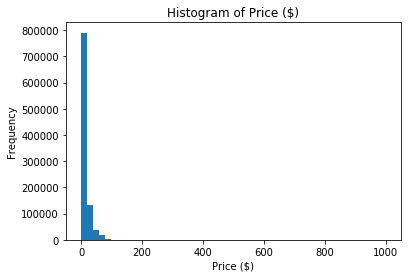

In [30]:
plt.hist(cab_data["total_amount"], bins=50)
plt.title("Histogram of Price ($)")
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

The histogram of the price feature is quite skewed: there seem to be a lot of trips with relatively low prices and a long-tail of trips with very high prices. Below, we generate a probability plot of our sample data against the quantiles of a normal distribution.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([ -1.18124694,  -1.15966257,  -1.15966257, ...,  49.26588698,
          52.80125761,  73.12033514])),
 (0.80562893254150347, -1.0662559962684076e-11, 0.80562467708200169))

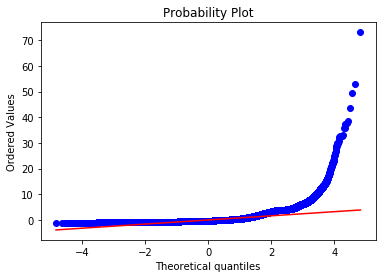

In [31]:
# First, standardize the total_amount data by subtracting by the mean and dividing by the standard deviation
std_total_amount = (cab_data["total_amount"] - np.mean(cab_data["total_amount"]))/np.std(cab_data["total_amount"])
stats.probplot(std_total_amount, dist="norm", plot=plt)

The fact that our data doesn't follow the red line (quantiles of the normal distribution) suggests that the distribution of the price is quite non-normal. This implies that a linear model will be a poor fit, since a linear model attempts to fit a Gaussian to the price. We try a log transform of the price feature below.

Text(0,0.5,'Frequency')

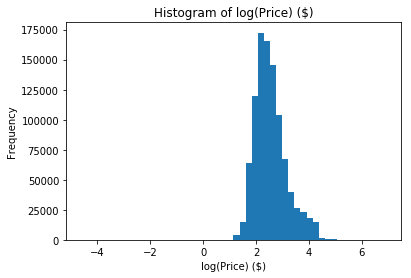

In [32]:
cab_data["log_total_amount"] = np.log(cab_data["total_amount"] + 1)
plt.hist(np.log(cab_data["total_amount"]), bins=50)
plt.title("Histogram of log(Price) ($)")
plt.xlabel('log(Price) ($)')
plt.ylabel('Frequency')

The plot above looks more normal, as evidenced by the qq plot below.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([ 0.00995033,  0.26236426,  0.26236426, ...,  6.52032653,
          6.58796315,  6.90705503])),
 (0.53922967709458047, 2.6428798090460202, 0.97236933129257075))

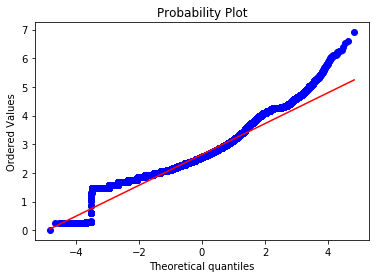

In [33]:
std_log_total_amount = (cab_data["log_total_amount"] - np.mean(cab_data["log_total_amount"]))/np.std(cab_data["log_total_amount"])
stats.probplot(cab_data["log_total_amount"], dist="norm", plot=plt)

Next, let's create a scatter plot of the price vs. the distance (miles) of the trip.

Text(0,0.5,'Price ($)')

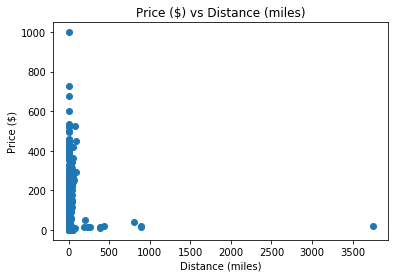

In [34]:
plt.scatter(cab_data["distance"], cab_data["total_amount"])
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

Notice that the majority of trips are clustered around distances between 0-500 miles, but there are a few trips with very large distances, one greater than 3500 miles! The scope of our model is NYC, so we shall filter out trips longer than a threshold of 50 miles (see the section: Linear Model Take 2).

Due to the large number of data points squashed in a very small region, we cannot glean any useful information about any trends between price and distance from the above plot. Instead, let's create a plot of price vs. distance for the first 1000 trips below.

Text(0,0.5,'Price ($)')

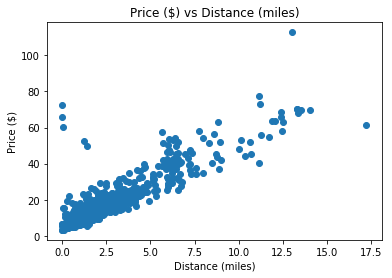

In [35]:
num_points = 1000
plt.scatter(cab_data["distance"][:num_points], cab_data["total_amount"][:num_points])
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

As might be expected, from the above plot (of a small subset of the trip data), we can observe a linear trend between the price of a trip and its distance (miles). One other approach we can try in the case of a large number of data points is to create a 2D histogram (heat map) of the data.

Text(0,0.5,'Price ($)')

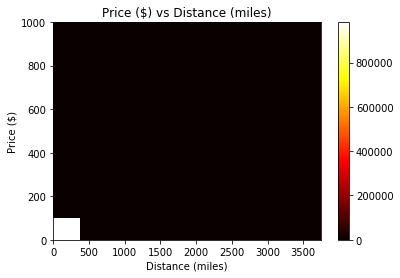

In [36]:
plt.hist2d(cab_data["distance"],cab_data["total_amount"],bins=10);
plt.colorbar();
plt.set_cmap('hot')
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

The heatmap also supports our conclusion: the vast majority of trips have a price of less than \$100 and a distance of less than 500 miles. How many trips have prices greater than \$100? 

In [37]:
high_prices = cab_data.loc[cab_data['total_amount'] >= 100]
print("%d trips cost more than $100" % len(high_prices))
print("The most expensive trip costs $%0.3f" % max(cab_data['total_amount']))
high_prices.head()

1348 trips cost more than $100
The most expensive trip costs $998.300


,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,end_latlng,distance,...,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility,log_total_amount
541,40.687695,-74.181274,40.785633,-73.969040,112.80,2016-04-18T08:38:22.000,2016-04-18T07:57:53.000,"40.687695, -74.181274","40.785633, -73.969040",13.029107,...,67,82,51,30,34,0.00,0.0,4,10,4.734443
1053,40.217884,-74.004501,40.724216,-74.006996,209.15,2016-04-07T02:29:58.000,2016-04-07T01:13:02.000,"40.217884, -74.004501","40.724216, -74.006996",34.936829,...,53,58,48,45,69,0.09,0.0,7,9,5.347822
2507,40.722610,-74.063568,40.770317,-73.867020,115.30,2016-04-08T10:54:51.000,2016-04-08T09:50:31.000,"40.722610, -74.063568","40.770317, -73.867020",10.827208,...,45,50,40,26,48,0.01,0.0,7,10,4.756173
2520,40.697224,-73.811440,40.781620,-73.979401,103.59,2016-04-03T01:07:46.000,2016-04-03T00:04:33.000,"40.697224, -73.811440","40.781620, -73.979401",10.565227,...,42,50,34,16,51,0.09,0.0,13,10,4.650048
2533,40.687714,-74.182350,40.644825,-73.781975,138.88,2016-04-02T19:40:58.000,2016-04-02T18:49:45.000,"40.687714, -74.182350","40.644825, -73.781975",21.243622,...,55,61,49,42,63,0.15,0.0,5,10,4.940785


We'll remember this point about the distribution of prices, when attempting to improve our initial model (see section: Linear Model Take 2).

## Linear Model Take 1

Having analyzed our data in the previous section, let's build a simple linear model to predict the price of a trip. Our first step is to define the subset of features from the original dataset that we wish to use in creating a price model.

In [38]:
feature_names = ['distance', 'duration', 'tpep_dropoff_datetime_years', 'tpep_dropoff_datetime_months',
       'tpep_dropoff_datetime_days', 'tpep_dropoff_datetime_hours',
       'tpep_dropoff_datetime_minutes', 'tpep_dropoff_datetime_seconds',
       'tpep_dropoff_datetime_day_of_week',
       'tpep_dropoff_datetime_is_holiday', 'tpep_pickup_datetime_years',
       'tpep_pickup_datetime_months', 'tpep_pickup_datetime_days',
       'tpep_pickup_datetime_hours', 'tpep_pickup_datetime_minutes',
       'tpep_pickup_datetime_seconds', 'tpep_pickup_datetime_day_of_week',
       'tpep_pickup_datetime_is_holiday', 'Mean Temperature',
       'Max Temperature', 'Min Temperature', 'Dew Point',
       'Average Humidity', 'Precipitation', 'Snow', 'Wind Speed',
       'Visibility']

Next, we create a numpy array holding the examples from our dataset. For each example, we extract the features that we defined above. We also create a list of the `log(price)` for each example.

In [39]:
def create_features(df, feature_names):
    features = []
    for feature_name in feature_names:
        features.append(df[feature_name])
    
    X = np.array(features).T
    y = df["log_total_amount"].values
    return (X,y)

(X,y) = create_features(cab_data, feature_names)

Next, we partition the data into training and testing splits, and further partition the training data into training and cross-validation splits.

In [40]:
def create_train_test_split(X,y):
    X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
    X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
    
    return (X_train, y_train, X_cv, y_cv, X_test, y_test)

(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)

Finally, we build a simple linear model on the training data and evaluate its performance by computing the mean squared error on the validation data. 

In [51]:
def train_linear_regression(X_train, y_train, X_test, y_test):
    model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    print("Mean squared error: %.5f" % error)
    return (model, y_pred, error)

(model, y_pred, error) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.06454


Below, we also define a utility function that takes in a data frame of test examples and a model, and returns a list of the model's predictions on the test examples, as well as the list of actual prices.

In [52]:
def predict(df, model):
    (X,y) = create_features(df)
    y_pred = model.predict(X)
    y_actual = df["log_total_amount"].values
    return y_pred, y_actual

## Linear Model Take 2

In the previous section, we developed a simple linear model that achieved a mean squared error of 0.10979 on the validation set. Can we do better? In the EDA section, we noticed that we had several outlier trips with really high distances and outliers with really high prices. Also, we noticed that some trips' pickup/dropoff location lat-lon coordinates were not even in NYC! Below, we filter the dataset according to these criteria.

In [53]:
def filter_data(cab_data):
    # Price range of trip: $[0,50]
    cab_data = cab_data[cab_data["total_amount"] >= 0]
    cab_data = cab_data[cab_data["total_amount"] <= 50]
    
    # Distance range of trip: [0,100] miles
    cab_data = cab_data[cab_data["distance"] >= 0]
    cab_data = cab_data[cab_data["distance"] <= 100]
    
    # Lat-Lon coordinates of NYC:
    # Latitude: [40.4,41]
    # Longitude: [-74.3, -73.5]
    cab_data = cab_data[cab_data['dropoff_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['dropoff_latitude'] <= 41]
    cab_data = cab_data[cab_data['dropoff_longitude'] >= -74.3]
    cab_data = cab_data[cab_data['dropoff_longitude'] <= -73.5]
    
    cab_data = cab_data[cab_data['pickup_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['pickup_latitude'] <= 41]
    cab_data = cab_data[cab_data['pickup_longitude'] >= -75]
    cab_data = cab_data[cab_data['pickup_longitude'] <= -72]
    
    return cab_data
cab_data = filter_data(cab_data)

Let's run our linear model on the filtered dataset. 

In [54]:
(X,y) = create_features(cab_data, feature_names)
(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)
(model, y_pred, error) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.06454


Great, we've improved our model's mean squared error on the validation data from 0.110 to 0.065! Let's take a look at our model's coefficients to interpret how our model is arriving at its estimated prices.

In [55]:
coeffs = model.coef_
for coeff,feature_name in zip(model.coef_, feature_names):
    print("Slope on feature %s is: %0.8f" % (feature_name, coeff))

Slope on feature distance is: 0.24414178
Slope on feature duration is: 0.00031976
Slope on feature tpep_dropoff_datetime_years is: -0.00000000
Slope on feature tpep_dropoff_datetime_months is: 1.92983951
Slope on feature tpep_dropoff_datetime_days is: 0.06453345
Slope on feature tpep_dropoff_datetime_hours is: 0.00690622
Slope on feature tpep_dropoff_datetime_minutes is: 0.00000669
Slope on feature tpep_dropoff_datetime_seconds is: 0.00000648
Slope on feature tpep_dropoff_datetime_day_of_week is: 0.01752429
Slope on feature tpep_dropoff_datetime_is_holiday is: 0.15100658
Slope on feature tpep_pickup_datetime_years is: 0.00000000
Slope on feature tpep_pickup_datetime_months is: -1.92201693
Slope on feature tpep_pickup_datetime_days is: -0.06305235
Slope on feature tpep_pickup_datetime_hours is: -0.00343917
Slope on feature tpep_pickup_datetime_minutes is: -0.00013180
Slope on feature tpep_pickup_datetime_seconds is: -0.00001118
Slope on feature tpep_pickup_datetime_day_of_week is: -0.02

One of the advantages of a simple linear model is its interpretability: A coefficient of 0.244 on distance suggests that an increase of one mile to the trip causes the price of the trip goes up by \$0.244 (holding all other variables constant). We can interpret features with really low weights, such as `tpep_pickup_datetime_years`, as having little influence on the predicted price. This makes sense, since the years feature is actually constant for all trips! Another interesting observation is the coefficient of -0.212 on is_holiday. This means that, all things equal, the price of a trip is $0.21 less on holidays!

## Gradient Boosting Model

Next, we try a more complicated model: the GradientBoostingRegressor provided by Sci-kit learn. This model consists of an ensemble of different regressors to boost performance, which you can read more about here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html. First, let's train the model.

In [73]:
clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Next, let's inspect the model's mean-squared errors on the training and validation sets. We also provide a baseline MSE achieved by predicting the mean price of the training data for all examples.

In [74]:
print("Training MSE: ", np.mean((clf.predict(X_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  0.0155140948981
Baseline training MSE:  0.223299264109


In [75]:
print("CV MSE: ", np.mean((clf.predict(X_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  0.0156961759282
Baseline CV MSE:  0.222950525042


We can see that our model seems to be learning - we're achieving significant improvement in MSE as compared to the baseline.

Below is a graph showing the training and testing MSE as a function of sample size. Notice that, interestingly, we get close to MSE of 0.02 on the validation set even after fitting a model on just the first 1000 samples!

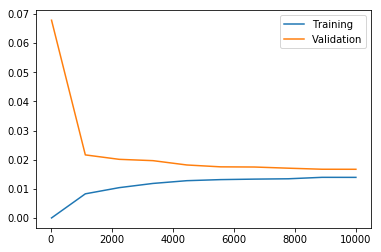

In [76]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([np.mean((clf.predict(X[:n_samples]) - y[:n_samples])**2), 
                     np.mean((clf.predict(X_cv) - y_cv)**2)])

n_samples = [int(x) for x in np.linspace(20, 10000, 10)] # 1000, 2000, ..., 10000
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a common way to speed up machine learning algorithms. PCA's [wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis) describes that PCA tends to convert possibly correlated variables into a set of linearly uncorrelated variables. PCA is commonly used as it is able to reduce data of high dimensionality to fewer dimensions, making it easier to analyze and train models on.

Applying PCA is pretty simple using Scikit-learn. There's a PCA class available in their library, that takes in the number of components and allows us to transform our data on the resulting number of dimensions. More information at: 




http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In the cell below, we will run PCA with Linear Regression. We will also run it for all the dimensions of the data to see the best number of dimensions for PCA. 

In [77]:
def applyPCAWithLR(X_train, y_train, X_test, y_test):
    numCols = X_train.shape[1]
    errors = []
    print(numCols)
    for i in range(numCols):
        print(i+1)
        # Initialize the PCA class and pass in the number of dimensions to which you want to reduce your data to.
        pca = PCA(n_components = i+1)

        # Fit the training data to the PCA model.
        pca.fit(X_train)

        # Reduce the dimensionality of the training set.
        newX_train = pca.transform(X_train)

        # Reduce the dimensionality of the testing set.
        newX_test = pca.transform(X_test)
        
        (model, y_pred, error) = train_linear_regression(newX_train, y_train, newX_test, y_test)
        errors.append(error)
    return errors

cvError = applyPCAWithLR(X_train, y_train, X_cv, y_cv)

27
1
Mean squared error: 0.21881
2
Mean squared error: 0.21856
3
Mean squared error: 0.21856
4
Mean squared error: 0.21855
5
Mean squared error: 0.21856
6
Mean squared error: 0.21855
7
Mean squared error: 0.21835
8
Mean squared error: 0.21834
9
Mean squared error: 0.21826
10
Mean squared error: 0.21826
11
Mean squared error: 0.21825
12
Mean squared error: 0.21825
13
Mean squared error: 0.21826
14
Mean squared error: 0.12460
15
Mean squared error: 0.08745
16
Mean squared error: 0.06481
17
Mean squared error: 0.06470
18
Mean squared error: 0.06468
19
Mean squared error: 0.06468
20
Mean squared error: 0.06458
21
Mean squared error: 0.06458
22
Mean squared error: 0.06455
23
Mean squared error: 0.06454
24
Mean squared error: 0.06454
25
Mean squared error: 0.06454
26
Mean squared error: 0.06454
27
Mean squared error: 0.06454


Now, we have a list of error values for each number of reduced dimensions. Using this, we can plot a graph of the error vs number of dimensions.

Text(0,0.5,'MSE')

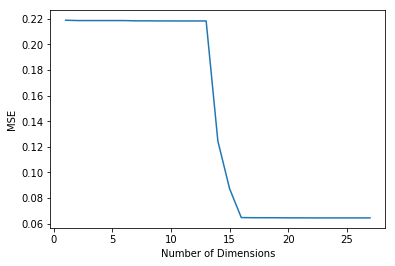

In [71]:
xAxisPlot = list(range(1, X_train.shape[1]+1))
plt.plot(xAxisPlot, cvError)
plt.xlabel('Number of Dimensions')
plt.ylabel('MSE')

In the above graph, it is visible that the error rate becomes mostly constant after 16 dimensions. Hence, for our data, 16 dimensions would be the best. 

Next, we will run PCA with Gradient Boosting using 16 dimensions, in an attempt to obtain even better results.

In [70]:
def applyPCA(X_train, X_test, numComponents):
    pca = PCA(n_components = numComponents)

    # Fit the training data to the PCA model.
    pca.fit(X_train)

    # Reduce the dimensionality of the training set.
    newX_train = pca.transform(X_train)

    # Reduce the dimensionality of the testing set.
    newX_test = pca.transform(X_test)
    
    return newX_train, newX_test

pcaX_train, pcaX_cv = applyPCA(X_train, X_cv, 16)
clfPCA = GradientBoostingRegressor()
clfPCA.fit(pcaX_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
print("Training MSE: ", np.mean((clfPCA.predict(pcaX_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  0.0166747462133
Baseline training MSE:  0.223299264109


In [67]:
print("CV MSE: ", np.mean((clfPCA.predict(pcaX_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  0.0168506091987
Baseline CV MSE:  0.222950525042


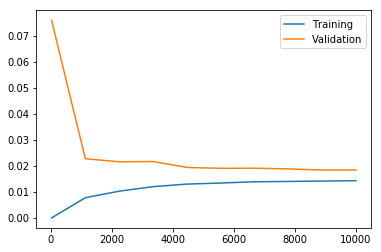

In [68]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([np.mean((clf.predict(X[:n_samples]) - y[:n_samples])**2), 
                     np.mean((clf.predict(X_cv) - y_cv)**2)])

n_samples = [int(x) for x in np.linspace(20, 10000, 10)] # 1000, 2000, ..., 10000
errors = np.array([get_err_samples(clfPCA, pcaX_train, y_train, pcaX_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])

Based on the cross-validated errors of each model, it seems that Gradient Boosting (without PCA) seems to be performing the best. Hence, we shall use this as our final model.

Finally, let's look at model's performance on the test set - a proxy for how our model will do on future trip data!

In [78]:
print("Test MSE: ", np.mean((clf.predict(X_test) - y_test)**2))
print("Baseline Test MSE: ", np.mean((np.mean(y_train) - y_test)**2))

Test MSE:  0.0167250077094
Baseline Test MSE:  0.22328588427


## Compare and Contrast with Uber

The outline for the comparison is as follows:

1) Specify an interval of time and a sampling rate for which we will make real-time queries to Uber for cab pricing.

2) Randomly select a subset of trips from the original dataset. We will use the starting and ending position of each trip only, and build the remaining features based off of current information (e.g current weather, current datetime, etc...).

3) For each randomly selected trip, make a real-time Uber request for pricing information for that trip. Also, generate features for that trip based on current information.

4) Input the generated features for current trip into our Model and get prediction.

5) Compare model predicted pricings to Uber pricings.

First, specify the time period (in minutes). Let's sample for 1 hour at a rate of 1 query per 5 minutes. This means we will make 60/5 = 12 queries to Uber API and therefore 12 sample trips.

In [25]:
#Step 1: Determine interval for sampling Uber API
time_period = 1*60 #In X hrs * 60 minutes 
sample_rate = 5 #In 1 sample per *sample_rate* minutes
num_samples = time_period // sample_rate
print("We will be making %d calls to uber API." % num_samples)

#Step 2: Get random subset of data to use as test points
cab_data = pd.read_csv("data_with_features.csv")
del cab_data["Unnamed: 0"]
del cab_data["Unnamed: 0.1"]
del cab_data["Unnamed: 0.1.1"]

#Filter out any nonzero price values
price_filter = cab_data["total_amount"] > 0
cab_data = cab_data[price_filter]

#Filter out any negative distance values
dist_filter = cab_data['distance'] > 0
cab_data = cab_data[dist_filter]

#Add the log total amount (for price verification)
cab_data["log_total_amount"] = np.log(cab_data["total_amount"] + 1)

#Randomly sample data
sample_data = cab_data.sample(n=num_samples)
sample_data = sample_data[['start_latlng', 'end_latlng', 'distance', 'duration']]
#print(sample_data)

We will be making 12 calls to uber API.


In [26]:
#List of features we are using in our model
feature_names = ['distance', 'duration', 'tpep_dropoff_datetime_years', 'tpep_dropoff_datetime_months',
       'tpep_dropoff_datetime_days', 'tpep_dropoff_datetime_hours',
       'tpep_dropoff_datetime_minutes', 'tpep_dropoff_datetime_seconds',
       'tpep_dropoff_datetime_day_of_week',
       'tpep_dropoff_datetime_is_holiday', 'tpep_pickup_datetime_years',
       'tpep_pickup_datetime_months', 'tpep_pickup_datetime_days',
       'tpep_pickup_datetime_hours', 'tpep_pickup_datetime_minutes',
       'tpep_pickup_datetime_seconds', 'tpep_pickup_datetime_day_of_week',
       'tpep_pickup_datetime_is_holiday', 'Mean Temperature',
       'Max Temperature', 'Min Temperature', 'Dew Point',
       'Average Humidity', 'Precipitation', 'Snow', 'Wind Speed',
       'Visibility']
print("Number of features: ", len(feature_names))

Number of features:  27


Now that we have our randomly sampled 12 trips, we can generate features for each trip and compute Uber estimates.

getPriceNow() is our interface for Uber API, and we can make a request for an Uber and get pricing information. The server_token is purposefully redacted.

In [38]:
# Gets the current price given the start and end locations.
def getPriceNow(startLat, startLong, endLat, endLong):
    # Left out the server token as the repo is public.
    session = Session(server_token="")
    client = UberRidesClient(session)

    response = client.get_price_estimates(
        start_latitude=startLat,
        start_longitude=startLong,
        end_latitude=endLat,
        end_longitude=endLong,
        seat_count=1
    )

    estimate = response.json.get('prices')

    return estimate

In [40]:
#Given a dataframe of trips, computes features for Model estimates and Uber estimates for pricing of each trip.
#Returns model features for each trips and uber prices
#Writes to "price_estimates.csv" and "price_features.csv"
def generate_estimates(sample_data):


    data_with_features = []
    uber_estimates = []

    for (idx,row) in sample_data.iterrows():

        ########## CREATE TIME/DATE/WEATHER FEATURES FOR MODEL ESTIMATE ###############
        F = open('price_estimates.csv', 'a')
        
        #Pickup time is now, dropoff is trip duration after pickup
        pickup_time = datetime.now()
        dropoff_time = pickup_time + timedelta(minutes=row['duration'])

        #Format start and end times for feature extraction
        start = datetime(pickup_time.year, pickup_time.month, pickup_time.day)
        start = '%4d-%02d-%02d' % (start.year, start.month, start.day)
        end = datetime(pickup_time.year, pickup_time.month, pickup_time.day + 1)
        end = '%4d-%02d-%02d' % (end.year, end.month, end.day)

        start_date = datetime(pickup_time.year, pickup_time.month, pickup_time.day)
        end_date = datetime(pickup_time.year, pickup_time.month, pickup_time.day)

        weather_date_features = init_weather_features(start_date, end_date)

        #Format pickup/dropoff time
        pickup_time = '%4d-%02d-%02dT%02d:%02d:%f' % (pickup_time.year, pickup_time.month, pickup_time.day, pickup_time.hour, pickup_time.minute, pickup_time.second)
        dropoff_time = '%4d-%02d-%02dT%02d:%02d:%f' % (dropoff_time.year, dropoff_time.month, dropoff_time.day, dropoff_time.hour, dropoff_time.minute, dropoff_time.second)
        #print(pickup_time, dropoff_time)
        curr_row = dict()
        curr_row["tpep_dropoff_datetime"] = str(dropoff_time)[:len(dropoff_time)-3] #strftime('%Y-%m-%dT%H:%M:%S.%f', dropoff_time)
        curr_row["tpep_pickup_datetime"] = str(pickup_time)[:len(pickup_time)-3] #strftime('%Y-%m-%dT%H:%M:%S.%f', pickup_time)

        curr_row['distance'] = row['distance']
        
        #Convert to dataframe and get date  + weather features
        curr_row = pd.DataFrame([curr_row])
        curr_row = create_date_features(curr_row, start, end)
        curr_row = create_weather_features(curr_row, weather_date_features)

        #Write the synthesized row of features to csv file (append)
        curr_row.to_csv("price_features.csv", mode='a',header=False)
        data_with_features.append(curr_row)

        ######### GET UBER ESTIMATE ##############
        start_coord = row['start_latlng'].split(',')
        end_coord = row['end_latlng'].split(',')
        #print(start_coord, end_coord, type(start_coord))
        curr_uber_estimates = getPriceNow(float(start_coord[0]), float(start_coord[1]), float(end_coord[0]), float(end_coord[1]))
        uberX_estimate = curr_uber_estimates[1]

        high_estimate = uberX_estimate['high_estimate']
        low_estimate = uberX_estimate['low_estimate']
        avg_estimate = (high_estimate + low_estimate) / 2

        all_estimates = (high_estimate, low_estimate, avg_estimate)
        
        uber_estimates.append(all_estimates)

        print("uberX estimate: %s" % (avg_estimate))
        F.write(str(all_estimates) + "\n")
        
        ####### COMPARE UBER ESTIMATE WITH MODEL ESTIMATE #########
        F.close()
        
        #Sleep for sample_rate minutes
        time.sleep(sample_rate * 60)
        #time.sleep(1)
    

    
    return (data_with_features, uber_estimates)

In [ ]:
#Generate estimates for our sampled_data
features, estimates = generate_estimates(sample_data)

uberX estimate: 10.5


Great! We now have our Uber estimates for each randomly selected trip (located in price_estimates.csv) as well as the generated features for each trip (price_features.csv). We can now parse both and input the features into our model to get price estimates. We will then compare the model pricing with Uber pricing.

In [47]:
X_test = pd.read_csv('price_features.csv')
del X_test['i']
del X_test['tpep_dropoff_datetime']
del X_test['tpep_pickup_datetime']
model_results = clf.predict(X_test)

In [48]:
uber_pricing_estimates = []
with open('price_estimates.csv', 'r') as f:
    r = csv.reader(f)
    uber_pricing_estimates = list(r)

uber_pricing_estimates.pop(0)

['min_estimate', ' max_estimate', ' avg_estimate']

In [49]:
assert(len(model_results) == len(uber_pricing_estimates))

for i in range(len(model_results)):
    uber_hi, uber_lo, uber_avg = uber_pricing_estimates[i]
    #Weird formatting stuff, ignore for now
    uber_avg = uber_avg[:len(uber_avg)-1]
    uber_hi = uber_hi[1:]

    our_estimate = model_results[i]
    
    print("For trip %d, Model: %f Uber: %s" % (i, np.exp(our_estimate) - 1, uber_avg))

For trip 0, Model: 17.383021 Uber:  15.0
For trip 1, Model: 19.705704 Uber:  20.5
For trip 2, Model: 22.013139 Uber:  62.0
For trip 3, Model: 11.886965 Uber:  13.0
For trip 4, Model: 13.222841 Uber:  12.5
For trip 5, Model: 12.499772 Uber:  9.5
For trip 6, Model: 8.502926 Uber:  9.5
For trip 7, Model: 15.662806 Uber:  17.0
For trip 8, Model: 14.926886 Uber:  15.0
For trip 9, Model: 27.800741 Uber:  54.0
For trip 10, Model: 7.680865 Uber:  9.5
For trip 11, Model: 8.050829 Uber:  9.5
For trip 12, Model: 12.435391 Uber:  11.5
For trip 13, Model: 7.639781 Uber:  9.5
For trip 14, Model: 11.748040 Uber:  55.0
For trip 15, Model: 6.424799 Uber:  12.0
For trip 16, Model: 13.233054 Uber:  14.0
For trip 17, Model: 12.642122 Uber:  10.5
For trip 18, Model: 7.695773 Uber:  9.5
For trip 19, Model: 7.695773 Uber:  9.5
For trip 20, Model: 20.873591 Uber:  18.0
For trip 21, Model: 17.542217 Uber:  16.0
For trip 22, Model: 25.820370 Uber:  26.0
For trip 23, Model: 6.711237 Uber:  9.5
For trip 24, Model